## Building a Neural Network

##### Problem Statement -
1) To build a 2 layer neural network with 30 neutron in the hidden layer from scratch using Python.  
2) To build the same neural network using Pytorch and compare the results.  
3) Try to use training tips and compare accuracies

#### Neural Network Without Pytorch

Let's define the task in detail:  
- Implement neural network to recognize handwritten digits using stochastic gradient descent and the MNIST data.
    - This implies we need to pass one image at a time.
- Defining the structure of the neural network
    - Input Layer: Our input layer contains 28x28 images. Converting these images into one array, we get 28x28 = 784 elements.
    - Hidden Layer: Here the number of nodes in the input layer is to be reduced to 30 nodes.
    - Output Layer: The output layer is reduced further to 10 nodes, so that we can evaluate the nodes aganist the labels.

#### Q1 - To build a 2 layer neural network with 30 neutron in the hidden layer from scratch using Python.

#### Import Required Packages

In [265]:
import numpy as np
from pkg_resources import DEVELOP_DIST
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [266]:
#Loading the data
data = datasets.fetch_openml('mnist_784')

In [333]:
#Convert the data to numpy array
X = data.data.to_numpy()
#convert the target label to numpy array
y = data.target.to_numpy()

def one_hot(Y):
    Y = Y.astype(np.int64)
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

#Checking the shape of both X and y
print("X Shape:", X.shape)
print("y Shape:", y.shape)

#Normalize the data by dividing it by 255 so that all the images have values between 0 and 1
X = (X/255).astype('float32')
X = np.array(X)


'''Transpose to feed 784 into the input layer'''

#Making the train(70%), validation(15%) and Test(15%) splits in X and y
X_train = X[0:42000].T 
X_valid = X[42000:51000].T
X_test = X[51000:60000].T

y_train = y[:42000]
y_valid = y[42000:51000]
y_test = y[51000:60000]

#Checking the shape of all the data after split
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_valid Shape:", X_valid.shape)
print("y_valid Shape:", y_valid.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

#Defining lists to store accuracy of train and validation
val_acc_list = []
train_acc_list = []

class NeuralNetwork:
    #initialize the class using a the init function
    def __init__(self, size, batch_size, epochs = 1, learning_rate = 0.005):
        self.size = size
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        #initialize the weights using the following function
        self.weight_params = self.initialize_weights()
        
        #To introduce bais
        self.bais_params = self.initialize_bais()

    '''Function for initializing weights'''
    def initialize_weights(self):
        #initializing each layer with the size, in our case 784, 30 and 10
        input_layer=self.size[0]
        hidden_layer=self.size[1]
        output_layer=self.size[2]
        
        #initializing weights
        '''As part of setting the hyperparameters, the weight initialization when multipled with *0.01 improves performance'''
        weight_params = {
            'W1':np.random.randn(hidden_layer, input_layer) *0.01,
            'W2':np.random.randn(output_layer, hidden_layer) * 0.01}
        
        return weight_params
    
    '''Function for initializing bias'''
    def initialize_bais(self):
        #initializing random bais for each layer
        '''As part of setting the hyperparameters, the bais initialization when multipled with *0.01 improves performance'''
        bais_params = {
            'b1':np.random.randn(30, 1)*0.01,
            'b2':np.random.randn(10, 1)*0.01
        }
        
        return bais_params
        
    '''Function for Forward Propogation'''
    def forward_propogation(self, X_train):
        cal_params = {}
        cal_params['A0'] = X_train
        
        #for each layer sequentially apply dot product and then followed by the activation function (sigmoid)
        cal_params['Z1'] = self.weight_params['W1'].dot(cal_params['A0']) + self.bais_params['b1']
        cal_params['A1'] = self.sigmoid(cal_params['Z1'])
        
        # hidden layer to output layer
        cal_params['Z2'] = self.weight_params['W2'].dot(cal_params['A1']) + self.bais_params['b2']
        
        #output layer activation function
        cal_params['A2'] = self.sigmoid(cal_params['Z2'])
        
        return cal_params
    
    '''activation function sigmoid for forward propogation'''
    def dev_sigmoid(self, x):
        return self.sigmoid(x) * (1-self.sigmoid(x))
    
    ''' derivative of sigmoid function for backpropogation'''
    def sigmoid(self, x):
        return (1/(1 + np.exp(-x)))
    
    '''loss function'''
    def NN_loss(self, y, A2):
        return np.sum((A2 - y)*(A2 - y)) * 1/y.size
        
    '''Function for Backward Propogation'''
    def backward_propogation(self, output, y_train):
        '''to calculate the error rate for W2 we need the output of forward propogation,
        which is A2 and we need to subtract with y_train to get the initial error
        '''
        drev_params = {}
        batch_size = y_train.size
        
        #One-hot encode the labels - will be easier to subtract these lables from the output of the network
        y_train = one_hot(y_train)

        #Cost function for output layer to hidden layer
        dZ2 =  1/batch_size * (output['A2'] - y_train) * (self.dev_sigmoid(output['Z2']))
        
        #Calculate the gradient of the weights and bias (output layer to hidden layer)
        drev_params['dW2'] = dZ2.dot(output['A1'].T)
        drev_params['db2'] = np.sum(dZ2, axis = 1)
        drev_params['db2'] = drev_params['db2'].reshape((10,1))
       
        #Cost function for hidden layer to input layer
        dZ1 = self.weight_params['W2'].T.dot(dZ2) * (self.dev_sigmoid(output['Z1']))
        
        #Calculate the gradient of the weights and bias (hidden layer to input layer)
        drev_params['dW1'] = dZ1.dot(output['A0'].T)
        drev_params['db1'] = np.sum(dZ1, axis = 1)
        drev_params['db1'] = drev_params['db1'].reshape((30,1))                                    
        
        return drev_params
    
    '''Fucntion to update parameters after backward propogation - happens after each epoch'''
    def update_parameters(self, drev_params):
        self.weight_params['W1'] = self.weight_params['W1'] - self.learning_rate * drev_params['dW1']
        self.bais_params['b1'] = self.bais_params['b1'] - self.learning_rate *drev_params['db1']
        self.weight_params['W2'] = self.weight_params['W2'] - self.learning_rate * drev_params['dW2']
        self.bais_params['b2'] = self.bais_params['b2'] - self.learning_rate * drev_params['db2']
    
    ''' Fcuntion to calculate accuray of the network'''
    def NN_accuracy(self, A2, y):
        A2 = A2.reshape(-1, 10)
        y = y.reshape(-1, 10)
        correct = (np.argmax(A2, axis=1) == np.argmax(y, axis=1)).sum() 
        
        return correct

    ''' Function to test the network'''  
    def test_NN(self, X, y):
        output = self.forward_propogation(X)
        A2 = output['A2']
        acc = self.NN_accuracy(A2, one_hot(y))
        mse_loss = self.NN_loss(one_hot(y), A2)
        
        return acc, mse_loss
    
    ''' Function to train the network'''  
    def train_NN(self, X, y):
        
        for i in range(self.epochs):
            train_acc = 0
            train_mse_loss = 0
            
            for j in range(0,X.shape[1],self.batch_size):
                #forward pass
                output = self.forward_propogation(X[:,j:j+self.batch_size])
                
                #backward pass
                drev_params = self.backward_propogation(output, y[j:j+self.batch_size])
                
                #update parameters
                self.update_parameters(drev_params)
                A2 = output['A2'] 
                
                #Train accuracy and loss
                train_acc += self.NN_accuracy(A2, one_hot(y[j:j+self.batch_size]))
                train_mse_loss += self.NN_loss(one_hot(y[j:j+self.batch_size]), A2)
            train_acc_list.append(train_acc*100/len(y))
            print('Epoch: {0}, Train_Accuracy: {1}, Train_Loss: {2}'.format(i+1, train_acc*100/len(y), train_mse_loss/len(y)))
            
            #Validation accuracy and loss
            val_acc,val_mse_loss = NN.test_NN( X_valid, y_valid)
            vaild_accuracy = val_acc*100/len(y_valid)
            val_acc_list.append(vaild_accuracy)
            print('Epoch: {0}, Val_Accuracy: {1}, Val_Loss: {2}'.format(i+1, vaild_accuracy , val_mse_loss/len(y_valid)))

            #Test accuracy and loss
        test_acc, test_mse_loss = NN.test_NN(X_test, y_test)
        print('Test_Accuracy: {0}, Test_Loss: {1}'.format((test_acc*100/len(y_test)), test_mse_loss/len(y_test)))


X Shape: (70000, 784)
y Shape: (70000,)
X_train Shape: (784, 42000)
y_train Shape: (42000,)
X_valid Shape: (784, 9000)
y_valid Shape: (9000,)
X_test Shape: (784, 9000)
y_test Shape: (9000,)


In [334]:
NN = NeuralNetwork(size=[784, 30, 10], batch_size = 1, epochs = 50)
NN.train_NN(X_train, y_train)

Epoch: 1, Train_Accuracy: 12.373809523809523, Train_Loss: 0.09054933617843063
Epoch: 1, Val_Accuracy: 22.955555555555556, Val_Loss: 9.813939240859302e-06
Epoch: 2, Train_Accuracy: 40.16428571428571, Train_Loss: 0.07495490429590393
Epoch: 2, Val_Accuracy: 71.13333333333333, Val_Loss: 6.670720291139263e-06
Epoch: 3, Train_Accuracy: 68.82142857142857, Train_Loss: 0.04921699640399183
Epoch: 3, Val_Accuracy: 46.22222222222222, Val_Loss: 4.624281815583087e-06
Epoch: 4, Train_Accuracy: 83.63095238095238, Train_Loss: 0.034743528757418235
Epoch: 4, Val_Accuracy: 84.27777777777777, Val_Loss: 3.3702999312716918e-06
Epoch: 5, Train_Accuracy: 87.72857142857143, Train_Loss: 0.025965862447254875
Epoch: 5, Val_Accuracy: 85.83333333333334, Val_Loss: 2.720733639105325e-06
Epoch: 6, Train_Accuracy: 89.25714285714285, Train_Loss: 0.021503513340518594
Epoch: 6, Val_Accuracy: 86.37777777777778, Val_Loss: 2.389767890925685e-06
Epoch: 7, Train_Accuracy: 90.07619047619048, Train_Loss: 0.019064976618549886
Epoc

Text(0, 0.5, 'Accuracy')

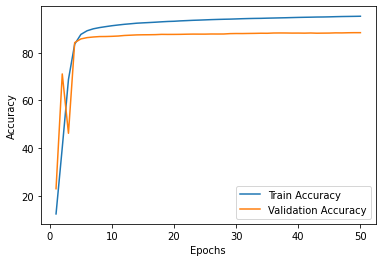

In [335]:
#plotting train and validation outputs
epochs_list = list(range(1, NN.epochs +1))
plt.plot(epochs_list, train_acc_list, label='Train Accuracy')
plt.plot(epochs_list, val_acc_list, label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### Using Pytroch

#### Q2 - To build the same neural network using Pytorch and compare the results

In [280]:
pip install torch

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [112]:
pip install torchvision

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [282]:
import torch
from torchvision import datasets, transforms #To import MNIST dataset
import torch.nn as nn
import torch.nn.functional as F

#### Load Data

In [283]:
#Access the MNIST dataset
traindata = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)

#Load the entire Data
trainloader_full = torch.utils.data.DataLoader(traindata, batch_size=len(traindata), shuffle=True)

'''Make the train (70%), validation (15%) and test (15%) splits'''
X_train_py, X_val_py, X_test_py = torch.utils.data.random_split(traindata, [42000, 9000,9000])

#Load train, validation and test data using DataLoader
X_train_py_loader = torch.utils.data.DataLoader(X_train_py, batch_size=1, shuffle=True)
X_val_py_loader = torch.utils.data.DataLoader(X_val_py, batch_size=len(X_val_py), shuffle=True)
X_test_py_loader = torch.utils.data.DataLoader(X_test_py, batch_size=len(X_test_py), shuffle=True)

#### Train Neural Net

In [306]:
#Initialize the layers for the neural network
input_layer = 784
hidden_layer = 30
output_layer = 10

#Define the Neural Network model using Sigmoid function
model = nn.Sequential(
    nn.Linear(input_layer, hidden_layer),
    nn.Sigmoid(),
    nn.Linear(hidden_layer, output_layer),
    nn.Sigmoid()
)

#creating lists to store accuracies and loss values
py_val_acc_list = []
py_train_acc_list = []
py_val_loss_list = []
py_train_loss_list = []

# Define a train Neural Network function 
def train_nn_pytroch(epochs, batch_size, mse_loss, optimizer):
    #Iterating for each epoch
    for epochs in range(epochs):

        #Iterating for each batch
        for batch_size, data in enumerate(X_train_py_loader):
            X_batch, y_batch = data
            
            #Forward propogation
            forward_output = model(X_batch.view(-1,784))
            
            #Calculating loss for the outputs
            loss = mse_loss(forward_output, F.one_hot(y_batch, num_classes=10).float())
            
            #Backward Propogation
            optimizer.zero_grad()
            loss.backward()

            #Updating the parameters after backward propogation
            optimizer.step()
        
        #Calculating the training accuray and loss for each epoch after training 
        for _,data in enumerate(trainloader_full):
            X, y = data
            forward_output = model(X.view(-1,784))

            #Training accurcay 
            train_accuracy = 100*(torch.argmax(forward_output,dim=1) == y).sum()/len(X)
            py_train_acc_list.append(train_accuracy)
            
            #Training loss
            train_loss = mse_loss(forward_output, F.one_hot(y, num_classes=10).float())
            py_train_loss_list.append(train_loss)

            print('Epochs:{0}, Train_Accuracy: {1}, Train_Loss: {2}'.format(epochs, train_accuracy, train_loss))
        
        #Calculating the Validation accuray and loss for each epoch 
        for _,data in enumerate(X_val_py_loader):
            X, y = data
            forward_output = model(X.view(-1,784))

            #Validation Accuracy
            validation_accuracy = 100*(torch.argmax(forward_output,dim=1) == y).sum()/len(X)
            py_val_acc_list.append(validation_accuracy)

            #Validation loss
            validation_loss = mse_loss(forward_output, F.one_hot(y, num_classes=10).float())
            py_val_loss_list.append(validation_loss)
            print('Epochs:{0}, Validation_Accuracy: {1}, Validation_Loss: {2}'.format(epochs, validation_accuracy, validation_loss))

In [299]:
#Calling the loss function - MSE Loss
mse_loss = nn.MSELoss()

#Optimizing using stochastic gradient descent 
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

#Define epochs
py_epochs = 30

#Training the neural network for the defined parameters
train_nn_pytroch(py_epochs,1, mse_loss, optimizer)

Epochs:0, Train_Accuracy: 25.815000534057617, Train_Loss: 0.08837579190731049
Epochs:0, Validation_Accuracy: 25.455554962158203, Validation_Loss: 0.088372603058815
Epochs:1, Train_Accuracy: 36.22666549682617, Train_Loss: 0.08454827964305878
Epochs:1, Validation_Accuracy: 36.03333282470703, Validation_Loss: 0.08460096269845963
Epochs:2, Train_Accuracy: 46.8466682434082, Train_Loss: 0.07586076855659485
Epochs:2, Validation_Accuracy: 46.72222137451172, Validation_Loss: 0.07597117125988007
Epochs:3, Train_Accuracy: 60.401668548583984, Train_Loss: 0.06605955958366394
Epochs:3, Validation_Accuracy: 60.155555725097656, Validation_Loss: 0.06618423759937286
Epochs:4, Train_Accuracy: 67.61499786376953, Train_Loss: 0.057044629007577896
Epochs:4, Validation_Accuracy: 67.19999694824219, Validation_Loss: 0.05715060606598854
Epochs:5, Train_Accuracy: 74.08333587646484, Train_Loss: 0.04987404868006706
Epochs:5, Validation_Accuracy: 73.94444274902344, Validation_Loss: 0.04993787035346031
Epochs:6, Trai

Text(0.5, 1.0, 'Pytroch - Accuracy vs No. of Epochs')

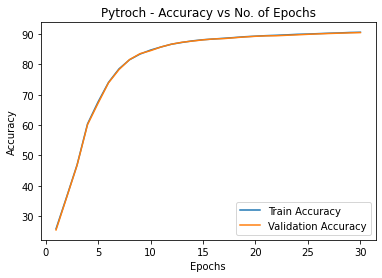

In [302]:
#Plotting train and validation outputs - pytroch
epochs_list_py = list(range(1, py_epochs +1))
plt.plot(epochs_list_py, py_train_acc_list, label='Train Accuracy')
plt.plot(epochs_list_py, py_val_acc_list, label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pytroch - Train Accuracy vs Validation Accuracy")

#### Q3 - Using training tips and compare accuracy

In [307]:
#Calling the loss function - Cross Entropy Loss
CrossEntroloss = nn.CrossEntropyLoss()

#Optimizing using Adam algorithm
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

#Define epochs
py_epochs = 30

#Training the neural network for the defined parameters
train_nn_pytroch(py_epochs,1, CrossEntroloss, adam_optimizer)

Epochs:0, Train_Accuracy: 91.88999938964844, Train_Loss: 1.5378748178482056
Epochs:0, Validation_Accuracy: 91.71111297607422, Validation_Loss: 1.5410925149917603
Epochs:1, Train_Accuracy: 91.163330078125, Train_Loss: 1.54116952419281
Epochs:1, Validation_Accuracy: 90.94444274902344, Validation_Loss: 1.5442345142364502
Epochs:2, Train_Accuracy: 92.46499633789062, Train_Loss: 1.5287505388259888
Epochs:2, Validation_Accuracy: 92.22222137451172, Validation_Loss: 1.5322840213775635
Epochs:3, Train_Accuracy: 93.12000274658203, Train_Loss: 1.5248360633850098
Epochs:3, Validation_Accuracy: 92.93333435058594, Validation_Loss: 1.5293197631835938
Epochs:4, Train_Accuracy: 92.81500244140625, Train_Loss: 1.532031536102295
Epochs:4, Validation_Accuracy: 92.44444274902344, Validation_Loss: 1.5362131595611572
Epochs:5, Train_Accuracy: 93.1500015258789, Train_Loss: 1.5263203382492065
Epochs:5, Validation_Accuracy: 92.94444274902344, Validation_Loss: 1.5303703546524048
Epochs:6, Train_Accuracy: 92.98166

Text(0.5, 1.0, 'Pytroch - Train Accuracy vs Validation Accuracy')

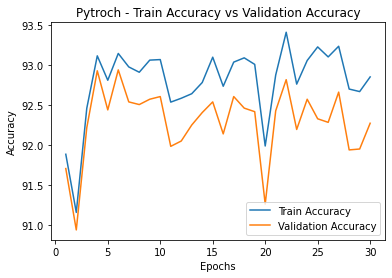

In [308]:
#Plotting train and validation outputs after using training tips
epochs_list_py = list(range(1, py_epochs +1))
plt.plot(epochs_list_py, py_train_acc_list, label='Train Accuracy')
plt.plot(epochs_list_py, py_val_acc_list, label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pytroch - Train Accuracy vs Validation Accuracy")

#### The use of training tips results in a better accuracy by a significant amount. When comparing the accuracies of the neural network using SDG and Adam shows an increase in accuracy by 2%